In [258]:
import os

import glob
import fitsio

import itertools

import numpy as np
import pylab as pl

import desisim.templates
import astropy.io.fits          as      fits

import desispec.io
import redrock.templates
import matplotlib.pyplot        as      plt

from   astropy.convolution      import  convolve, Box1DKernel
from   desispec.spectra         import  Spectra
from   desispec.frame           import  Frame
from   desispec.resolution      import  Resolution
from   desispec.io.meta         import  findfile
from   desispec.io              import  read_frame, read_fiberflat, read_flux_calibration, read_sky, read_fibermap 

from   desispec.interpolation   import  resample_flux

from   astropy.table            import  Table
from   desispec.io.image        import  read_image

from   specter.psf.gausshermite import  GaussHermitePSF
from   scipy.signal             import  medfilt

# Foundations to 1004 desispec ticket:  Template SNR and LSS rad. weights.

Template SNR:

https://desi.lbl.gov/DocDB/cgi-bin/private/RetrieveFile?docid=4723;filename=sky-monitor-mc-study-v1.pdf;version=2

applied to SV0 dataset:

https://desi.lbl.gov/trac/wiki/TargetSelectionWG/SV0

In [2]:
expid  = 55382

# Should be derivable.
tile   = 67230
flatid = 55530

# Template SNR

$\Huge \langle tSNR^2 \rangle = \sum_{grz} \sum_{\lambda \in grz} \frac{\tau^2 T^2 \langle \Delta F^2 \rangle}{\sigma_e^2 \cdot {\rm NPIX} + \tau T_{\rm sky}  F_{\rm sky}}$

_"We choose to normalize it such that zSNR = 3 for a 1000 sec dark time exposure in
nominal conditions."_

Here:  
- $\sigma_e$ is the READNOISE in units of ELECTRONS / PIXEL. 
- NPIX is the projected fiber area in units of PIXELS for a width of **ONE ANGSTROM**.  
- $\Delta F$ is the residual (template) flux from a 100A filtered equivalent.
- $\tau$ is the exposure time, already included in the flux calib.
- $T_{\rm sky} F_{\rm sky}$ is the estimated fiber sky flux in units of ELECTRONS PER ANGSTROM.

In [4]:
def templateSNR(template_flux, sky_flux=None, flux_calib=None, fiberflat=None, readnoise=None, npix=None, angstroms_per_pixel=None, fiberloss=None, flux_ivar=None):
    """
        Creates a spectroscopic radial weights.
        
        Args:
            template_flux: ergs/s/cm2/A 
            sky_flux: electrons/A
            flux_calib: 
            readnoise:electrons/pixel
            npix:
            angstroms_per_pixel: in the wavelength direction.
            fiberloss:
            flux_ivar: Equivalent to calibrated flux [ergs/s/cm2/A]. 
            
        Optional inputs:
            ...

        Returns:
            template S/N per camera.
    """
    # dlambda per pixel = 0.8; 100A / dlambda per pixel = 125. 
    sflux = convolve(template_flux, Box1DKernel(125))  
    dflux = template_flux - sflux 
    
    if flux_ivar is not None:
        # Work in calibrated flux units.
        # Assumes Poisson Variance from source is negligible.
        return  np.sum(flux_ivar * dflux ** 2.)

    else: 
        # Work in uncalibrated flux units (electrons per angstrom); flux_calib includes exptime. tau.
        dflux  *= flux_calib    # [e/A]
 
        # Wavelength dependent fiber flat;  Multiply or divide - check with Julien. 
        result *= fiberflat

        result  = dflux * dflux
    
        lossless_fluxcalib = flux_calib / fiberloss
    
        # RDNOISE & NPIX assumed wavelength independent.
        # TO DO:  How to deal with fiberflat here?  Relative between two fibers? 
        denom   = readnoise**2 * npix / angstroms_per_pixel + fiberflat * sky_flux
        
        result /= denom
        
        # Eqn. (1) of https://desi.lbl.gov/DocDB/cgi-bin/private/RetrieveFile?docid=4723;filename=sky-monitor-mc-study-v1.pdf;version=2
        return  np.sum(result)

# Rad. Weights Class Definition

In [366]:
class RadWeights(object):
    def __init__(self, expid, tile, flatid, cameras=None, andes=None):
        """
        Creates a spectroscopic rad(ial) weights instance.
        
        Args:
            night: 
            expid: 
            
        Optional inputs:
            andes: 
        """
        
        if andes is None:
            # /global/cfs/cdirs/desi/spectro/redux/andes/'
            self.andes  = '/global/scratch/mjwilson/desi-data.dm.noao.edu/desi/spectro/redux/andes/'

        # os.environ['DESIMODEL']          = '/global/common/software/desi/cori/desiconda/20200801-1.4.0-spec/code/desimodel/0.13.0' 
        os.environ['DESIMODEL']            = '/global/scratch/mjwilson/miniconda3/envs/desi/code/desimodel/'
        os.environ['DESI_BASIS_TEMPLATES'] = '/global/scratch/mjwilson/desi-data.dm.noao.edu/desi/spectro/templates/basis_templates/v3.1/'

        self.tileid           = tile
        self.expid            = expid
        self.flatid           = flatid
        self.cameras          = cameras
        
        self.nmodel           =  0
        self.ensemble_tracers = []
        self.ensemble_flux    = {}
        self.ensemble_meta    = {}
        self.ensemble_objmeta = {}          
        
        self.get_gfas()
        self.get_data()

        self.outdir           = self.andes  + '/exposures/{}/{:08d}'.format(self.night, self.expid)
        self.qadir            = self.outdir + '/RADQA/'
        
    def get_gfas(self, printit=False, root='/global/scratch/mjwilson'):
      gfa = Table.read(root + '/offline_all_guide_ccds_SV0.fits')
    
      # Quality cuts. 
      gfa = gfa[gfa['SPECTRO_EXPID'] > -1]
      gfa = gfa[gfa['N_SOURCES_FOR_PSF'] > 2]
      gfa = gfa[gfa['CONTRAST'] > 2]
      gfa = gfa[gfa['NPIX_BAD_TOTAL'] < 10]

      gfa.sort('SPECTRO_EXPID')

      by_spectro_expid = gfa.group_by('SPECTRO_EXPID')

      # np.mean
      self.gfa_median  = by_spectro_expid.groups.aggregate(np.median)
 
      self.gfa_median_exposure = self.gfa_median[self.gfa_median['SPECTRO_EXPID'] == expid]

      self.gfa_median_exposure = self.gfa_median_exposure['SPECTRO_EXPID', 'FWHM_ASEC', 'TRANSPARENCY', 'FIBER_FRACFLUX', 'SKY_MAG_AB', 'MJD', 'NIGHT']
    
      self.night       = np.int(self.gfa_median_exposure['NIGHT'])
      self.fiberloss   = self.gfa_median_exposure['FIBER_FRACFLUX'][0]
        
      if printit:
          print(self.gfa_median)
       
    def get_data(self):    
        # For each camera.
        self.frames     = {}
        self.cframes    = {}

        self.psfs       = {}
        self.skies      = {} 

        self.fluxcalibs = {}

        self.fiberflats = {}  # NOT including in the flux calibration. 
    
        self.fibermaps  = {} 
        
        self.psf_nights = {}

        self.preprocs   = {}

        if self.cameras is None:
            petals       = np.arange(10)
            self.cameras = [x[0] + x[1] for x in itertools.product(['b', 'r', 'z'], petals.astype(np.str))]
                
        else:
            self.cameras = self.cameras
            
        for cam in self.cameras:
            # E.g.  /global/cfs/cdirs/desi/spectro/redux/andes/tiles/67230/20200314/cframe-z9-00055382.fits                      
            self.cframes[cam]    = read_frame(findfile('cframe', night=self.night, expid=self.expid, camera=cam, specprod_dir=self.andes))
                     
            self.exptime         = self.cframes[cam].meta['EXPTIME']
        
            self.mjd             = self.cframes[cam].meta['MJD-OBS']
            
            self.night           = self.cframes[cam].meta['NIGHT']
                
            self.fibermaps[cam]  = self.cframes[cam].fibermap
                     
            self.fibermaps[cam]['TILEFIBERID'] = 10000 * self.tileid + self.fibermaps[cam]['FIBER']
                
            self.psfs[cam]       = GaussHermitePSF(findfile('psf', night=self.night, expid=self.expid, camera=cam, specprod_dir=self.andes))

            self.psf_nights[cam] = GaussHermitePSF(findfile('psfnight', night=self.night, expid=self.expid, camera=cam, specprod_dir=self.andes))
                
            self.skies[cam]      = read_sky(findfile('sky', night=self.night, expid=self.expid, camera=cam, specprod_dir=self.andes))
        
            # https://desidatamodel.readthedocs.io/en/latest/DESI_SPECTRO_CALIB/fluxcalib-CAMERA.html
            self.fluxcalibs[cam] = read_flux_calibration(findfile('fluxcalib', night=self.night, expid=self.expid, camera=cam, specprod_dir=self.andes))
        
            # Book keeping on what exposure was the fiberflat.  Taken once per night. 
            self.fiberflats[cam] = read_fiberflat(findfile('fiberflat', night=self.night, expid=self.flatid, camera=cam, specprod_dir=self.andes))
        
            self.frames[cam]     = read_frame(findfile('frame', night=self.night, expid=self.expid, camera=cam, specprod_dir=self.andes))
                
            self.preprocs[cam]   = read_image(findfile('preproc', night=self.night, expid=self.expid, camera=cam, specprod_dir=self.andes))
            
    def calc_nea(self, psf_wave=None, write=False):
        for cam in self.cameras:
            psf = self.psf_nights[cam]
            
            # Note:  psf.nspec, psf.npix_x, psf.npix_y
            
            if psf_wave is None:
              # Representative wavelength. 
              psf_wave = 3727. * (1. + 1.1)    
            
            if (psf_wave < rads.cframes[cam].wave.min()) | (psf_wave > rads.cframes[cam].wave.max()):
                psf_wave = np.median(rads.cframes[cam].wave)
               
            fiberids = self.fibermaps[cam]['FIBER']
                
            #  Fiber centroid position on CCD.
            #  https://github.com/desihub/specter/blob/f242a3d707c4cba549030af6df8cf5bb12e2b47c/py/specter/psf/psf.py#L467
            #  x,y = psf.xy(fiberids, self.psf_wave)
            
            #  https://github.com/desihub/specter/blob/f242a3d707c4cba549030af6df8cf5bb12e2b47c/py/specter/psf/psf.py#L300
            #  Range that boxes in fiber 'trace':  (xmin, xmax, ymin, ymax)
            #  ranges = psf.xyrange(fiberids, self.psf_wave)
            
            #  Note:  Expectation of 3.44 for PSF size in pixel units (spectro paper).
            #  Return Gaussian sigma of PSF spot in cross-dispersion direction in CCD pixel units.
            #  Gaussian PSF, radius R that maximizes S/N for a faint source in the sky-limited case is 1.7σ
            #  http://www.ucolick.org/~bolte/AY257/s_n.pdf
            #  2. * 1.7 * psf.xsigma(ispec=fiberid, wavelength=oii)
            
            #  Gaussian sigma of PSF spot in dispersion direction in CCD pixel units.
            #  Gaussian PSF, radius R that maximizes S/N for a faint source in the sky-limited case is 1.7σ
            #  http://www.ucolick.org/~bolte/AY257/s_n.pdf
            #  2. * 1.7 * psf.ysigma(ispec=fiberid, wavelength=oii)
           
            neas             = []
            angstrom_per_pix = []
    
            for fiberid in fiberids:
              psf_2d = psf.pix(ispec=fiberid, wavelength=psf_wave)
            
              # norm = np.sum(psf_2d)
             
              # http://articles.adsabs.harvard.edu/pdf/1983PASP...95..163K
              neas.append(1. / np.sum(psf_2d ** 2.)) # [pixel units].

              angstrom_per_pix.append(psf.angstroms_per_pixel(fiberid, psf_wave))

            self.fibermaps[cam]['NEA']              = np.array(neas)
            self.fibermaps[cam]['ANGSTROMPERPIXEL'] = np.array(angstrom_per_pix)
            
            if write:
                raise  NotImplementedError()
                
    def calc_readnoise(self, psf_wave=None):
            self.ccdsizes          = {}
            
            for cam in self.cameras:
                self.ccdsizes[cam] = self.cframes[cam].meta['CCDSIZE']
            
                psf                = self.psf_nights[cam]
                        
                if psf_wave is None:
                  # Representative wavelength. 
                  psf_wave = 3727. * (1. + 1.1)    
            
                if (psf_wave < rads.cframes[cam].wave.min()) | (psf_wave > rads.cframes[cam].wave.max()):
                  psf_wave = np.median(rads.cframes[cam].wave)
               
                fiberids = self.fibermaps[cam]['FIBER']
        
                rd_noises = []
        
                for fiberid in fiberids:                
                    x, y                     = psf.xy(fiberid, psf_wave)
    
                    (xmin, xmax, ymin, ymax) = psf.xyrange(fiberid, psf_wave)

                    # electrons/pixel (float).
                    rd_cutout = self.preprocs[cam].readnoise[ymin:ymax, xmin:xmax]
                    
                    rd_noises.append(np.median(rd_cutout))
                                
                self.fibermaps[cam]['RDNOISE'] = np.array(rd_noises)
                            
                # TO DO:  Compare fiber (x,y) to quadrants.
                # for ccd_quad in ['A', 'B', 'C', 'D']:
                #   print('CCD Quadrant {}\t{}'.format(ccd_quad, cframes['z'].meta['OBSRDN{}'.format(ccd_quad)]))
            
    def calc_skycontinuum(self):
        # kernel_N      = 145
        # sky_continuum = medfilt(skies['z'].flux[0, :], kernel_N)

        # pl.plot(skies['z'].wave, sky_continuum)

        # pl.xlabel('Wavelength [Angstroms]')
        # pl.ylabel('Electrons per Angstrom')

        # pl.title('Sky continuum ({}A median filter)'.format(kernel_N * 0.8))
        raise  NotImplementedError()

    def gen_template_ensemble(self, tracer='ELG', nmodel=1):                
        def tracer_maker(wave, tracer='ELG', nmodel=10):
            if tracer == 'ELG':
                maker = desisim.templates.ELG(wave=wave)
                
            elif tracer == 'QSO':
                maker = desisim.templates.QSO(wave=wave)
    
            else:
                raise  ValueError('{} is not an available tracer.'.format(tracer))

            flux, wave, meta, objmeta = maker.make_templates(nmodel=nmodel)
        
            return  wave, flux, meta, objmeta

        for cam in self.cameras:
            band                               = cam[0]

            if (not band in self.ensemble_flux.keys()) | (self.nmodel != nmodel):            
                # Where is the per band wavelength arrays defined?
                # self.cframes['r0'].wave, self.cframes['z0'].wave
                keys                           = set([key for key in self.cframes.keys() if key[0] in ['b','r','z']])
                keys                           = np.array(list(keys))
                                                        
                wave                           = self.cframes[keys[0]].wave
                                
                if len(keys) > 1:
                    for key in keys[1:]:
                        wave                   = np.concatenate((wave, self.cframes[key].wave))
                
                wave                           = np.unique(wave) # sorted.
                wave, flux, meta, objmeta      = tracer_maker(wave=wave, tracer=tracer, nmodel=nmodel)

                meta['MAG_G']                  = 22.5 - 2.5 * np.log10(meta['FLUX_G'])
                meta['MAG_R']                  = 22.5 - 2.5 * np.log10(meta['FLUX_R'])
                meta['MAG_Z']                  = 22.5 - 2.5 * np.log10(meta['FLUX_Z'])

                self.nmodel                    = nmodel
                self.ensemble_tracers.append(tracer)
                
                for band in ['b', 'r', 'z']:
                    band_key                   = [x[0] == band for x in keys]
                    band_key                   = keys[band_key][0]
                                            
                    band_wave                  = self.cframes[band_key].wave
                    
                    in_band                    = np.isin(wave, band_wave)
                    
                    self.ensemble_flux[band]   = flux[:, in_band]
                    self.ensemble_meta         = meta
                    self.ensemble_objmeta      = objmeta
    
    def calc_templatesnrs(self, calibrated=True):
        self.template_snrs          = {}
        
        if  len(self.ensemble_flux.keys()) == 0:
            self.calc_template_ensemble()
        
        for cam in self.cameras:  
            band                    = cam[0]
            
            nfiber                  = len(self.fibermaps[cam]['FIBER'])
            nmodel                  = len(self.ensemble_meta)
                
            self.template_snrs[cam] = np.zeros((nfiber, nmodel)) 

            for i, fiber in enumerate(self.fibermaps[cam]['FIBER']):
                for j, template_flux in enumerate(self.ensemble_flux[band]):
                    sky_flux        = self.skies[cam].flux[fiber,:]
                    flux_calib      = self.fluxcalibs[cam].calib[fiber,:]
                
                if not calibrated:
                    self.template_snrs[cam][i, j] = templateSNR(template_flux, sky_flux=sky_flux, flux_calib=flux_calib,
                                                                fiberflat=None, readnoise=None, npix=None,
                                                                angstroms_per_pixel=None, fiberloss=None,
                                                                flux_ivar=None)
                    
                else:
                    flux_ivar                     = self.cframes[cam].ivar[i, :]    
                    self.template_snrs[cam][i, j] = templateSNR(template_flux, flux_ivar=flux_ivar)
    
    def gen_redrock_cframes(self, flux_realization_ivar=False):
        templates = dict()

        for filename in redrock.templates.find_templates():
            t = redrock.templates.Template(filename)
            templates[(t.template_type, t.sub_type)] = t

        self.rr_cframes = {}
        self.zbests     = {}
            
        for cam in self.cameras:
          petal      = cam[1] 
            
          # E.g. /global/scratch/mjwilson/desi-data.dm.noao.edu/desi/spectro/redux/andes/tiles/67230/20200314
          zbest_file = os.path.join(self.andes, 'tiles', str(self.tileid), str(self.night), 'zbest-{}-{}-{}.fits'.format(petal, self.tileid, self.night))
             
          self.zbests[cam] = zbest = Table.read(zbest_file, 'ZBEST')
                          
          rr_z       = zbest['Z']

          spectype   = [x.strip() for x in zbest['SPECTYPE']]
          subtype    = [x.strip() for x in zbest['SUBTYPE']]

          fulltype   = list(zip(spectype, subtype))
          
          ncoeff     = [templates[ft].flux.shape[0] for ft in fulltype]
 
          coeff      = [x[0:y] for (x,y) in zip(zbest['COEFF'], ncoeff)]
          
          tfluxs     = [templates[ft].flux.T.dot(cf)   for (ft, cf) in zip(fulltype, coeff)]
          twaves     = [templates[ft].wave * (1. + rz) for (ft, rz) in zip(fulltype, rr_z)]  

          Rs         = [Resolution(x) for x in self.cframes[cam].resolution_data]
          txfluxs    = [R.dot(resample_flux(self.cframes[cam].wave, twave, tflux)).tolist() for (R, twave, tflux) in zip(Rs, twaves, tfluxs)]
          txfluxs    = np.array(txfluxs)
            
          # txflux  *= self.fluxcalibs[cam].calib     # [e/A].
          # txflux  /= self.fiberflats[cam].fiberflat # [e/A] (Instrumental).   

          # Estimated sourceless IVAR [ergs/s/A] ...  
          # Note:  assumed Poisson in Flux.
          if flux_realization_ivar:
            var      = (1. / self.cframes[cam].ivar) - self.cframes[cam].flux 
            
          else:  
            var      = (1. / self.cframes[cam].ivar) - txfluxs
            
          ivar       =  1. / var
            
          # https://github.com/desihub/desispec/blob/6c9810df3929b8518d49bad14356d35137d25a89/py/desispec/frame.py#L41  
          self.rr_cframes[cam] = Frame(self.cframes[cam].wave, txfluxs, ivar, mask=self.cframes[cam].mask, resolution_data=self.cframes[cam].resolution_data, fibermap=self.cframes[cam].fibermap, meta=self.cframes[cam].meta)

          rr_tsnrs   = []
            
          for j, template_flux in enumerate(self.rr_cframes[cam].flux):  
              # Calibrated flux units.  
              rr_tsnrs.append(templateSNR(template_flux, flux_ivar=self.cframes[cam].ivar[j,:]))  
        
          self.cframes[cam].fibermap['TSNR'] = np.array(rr_tsnrs)
            
    def gen_redrock_2Dframes(self, extract=False):
        from specter.extract.ex2d import ex2d
        
        
        self.rr_2Dframes                      = {}
        self.self.rr_2Dframe_spectroperf_ivar = {}
            
        for cam in self.cameras:
          psf        = self.psf_nights[cam]

          wave       = self.cframes[cam].wave
          nwave      = len(wave)
        
          nspec      = len(self.rr_cframes[cam].flux)
        
          xyrange    = (xmin, xmax, ymin, ymax) = psf.xyrange((0, nspec), wave)
          nx         = xmax - xmin
          ny         = ymax - ymin
        
          influx     = self.rr_cframes[cam].flux
        
          #- Generate a noiseless truth image and a noisy image (Poisson + read noise)
          # true_img   = psf.project(wave, influx*np.gradient(wave), xyrange=xyrange)

          # read_noise = np.median(self.fibermaps[cam]['RDNOISE'])
          # noisy_img  = np.random.poisson(true_img) + np.random.normal(scale=read_noise, size=true_img.shape)

          # self.rr_2Dframes[cam] = noisy_img  
        
          #- Run extractions with true ivar and estimated ivar
          # true_ivar     = 1.0 / (true_img + read_noise * read_noise)

          if extract:
            # IVAR by 'Spectro-Perfectionism'.
            flux, ivar, R1 = ex2d(noisy_img, true_ivar, psf, 0, nspec, wave, xyrange=xyrange)

            self.rr_2Dframe_spectroperf_ivar[cam] = ivar
    
            #- Resolution convolved influx -> model
            # model       = np.zeros((nspec, nwave))

            #  for i in range(nspec):
            #    model[i] = Resolution(R1[i]).dot(influx[i])

    def run_ensemble_redrock(self, output_dir='/global/scratch/mjwilson/'):
        for cam in self.cameras:        
          band = cam[0]
            
          # TODO:  Add resolution, mask and sky noise to template flux for camera.  
          spec = Spectra([cam], {cam: self.cframes[cam].wave}, {cam: self.ensemble_flux[band]}, {cam: self.cframes[cam].ivar[:self.nmodel]}, 
                          resolution_data={cam: self.cframes[cam].resolution_data[:self.nmodel,:,:]}, 
                          mask={cam: self.cframes[cam].mask[:self.nmodel]}, 
                          fibermap=self.cframes[cam].fibermap[:self.nmodel], 
                          meta=None,
                          single=False)
        
        # Overwrites as default.
        desispec.io.write_spectra(output_dir + '/spec_test.fits', spec)
        
        # https://github.com/desihub/tutorials/blob/master/simulating-desi-spectra.ipynb
        zbest_file = os.path.join(output_dir, 'test-zbest.fits')

        os.system('rm {}'.format(zbest_file))
        
        cmd   = 'rrdesi {} --zbest {}'.format(os.environ['RESULTS'] + '/spec_test.fits', zbest_file)
        srun  = 'srun -A desi -N 1 -t 00:10:00 -C haswell --qos interactive'
        cmd   = '{} {} --mp 32'.format(srun, cmd)

        print(cmd)
       
    def write_radweights(self, output_dir='/global/scratch/mjwilson/'):
        '''
        Each exposure, each fiber, a redshift efficiency as a function of redshift and target magnitude,
        per target class.  This could be for instance in the form of fits images in 3D
        (fiber x redshift x magnitude), with one HDU per target class, and one fits file per tile.
        '''
        for cam in self.cameras:            
          hdr             = fits.open(findfile('cframe', night=self.night, expid=self.expid, camera=cam, specprod_dir=self.andes))[0].header

          hdr['EXTNAME']  = 'RADWEIGHT'

          primary         = fits.PrimaryHDU(header=hdr)
          
          hdu_list        = [primary] + [fits.ImageHDU(self.template_snrs[cam], name=tracer) for tracer in self.ensemble_tracers]  
 
          all_hdus        = fits.HDUList(hdu_list)

          all_hdus.writeto(self.outdir + '/radweights-{}-{:08d}.fits'.format(cam, self.expid), overwrite=True)
    
    def qa_plots(self, plots_dir=None):
        from pathlib import Path
        
        if plots_dir is None:
            plots_dir = self.qadir
        
        for cam in self.cameras:
          # ---------------  Skies  ---------------  
          pl.clf()
          pl.plot(self.skies[cam].wave, self.skies[cam].flux[0, :].T)
          pl.xlabel('Wavelength [Angstroms]')
          pl.ylabel('Electrons per Angstrom')
        
          Path(plots_dir + '/skies/').mkdir(parents=True, exist_ok=True)
        
          pl.savefig(plots_dir + '/skies/sky-{}.pdf'.format(cam))
        
          # ---------------  Flux calibration  ---------------
          fluxcalib          = self.fluxcalibs[cam].calib[0,:].T
          lossless_fluxcalib = fluxcalib / self.fiberloss 

          wave               = self.cframes[cam].wave
  
          pl.clf()
          pl.plot(wave, fluxcalib,          label='Flux calib.')
          pl.plot(wave, lossless_fluxcalib, label='Lossless flux calib.')

          pl.title('FIBERLOSS of {:.2f}'.format(self.fiberloss))

          pl.legend(loc=0, frameon=False)
            
          Path(plots_dir + '/fluxcalib/').mkdir(parents=True, exist_ok=True)
            
          pl.savefig(plots_dir + '/fluxcalib/fluxcalib-{}.pdf'.format(cam))  
        
          # ---------------  Fiber flats  ---------------
          xs = self.fibermaps[cam]['FIBERASSIGN_X']
          ys = self.fibermaps[cam]['FIBERASSIGN_Y']

          # Center on zero.
          fs = self.fiberflats[cam].fiberflat[:,0]
        
          pl.clf()
          pl.scatter(xs, ys, c=fs, vmin=0.0, vmax=2.0, s=2)
        
          Path(plots_dir + '/fiberflats/').mkdir(parents=True, exist_ok=True)
        
          pl.savefig(plots_dir + '/fiberflats/fiberflat-{}.pdf'.format(cam)) 
            
          # --------------- Template meta  ---------------
          # fig, axes = plt.subplots(1, 3, figsize=(20, 5))
  
          # for i, (band, color) in enumerate(zip(['MAG_G', 'MAG_R', 'MAG_Z'], ['b', 'g', 'r'])):
          #    axes[i].plot(meta[band], meta['REDSHIFT'], marker='.', c=color, lw=0.0)

          #    axes[i].set_xlabel('$REDSHIFT$')
          #    axes[i].set_ylabel('$' + band + '$')  
           
    def compute(self):
            self.calc_nea()
            
            self.calc_readnoise()
            
            self.gen_template_ensemble()
            
            self.calc_templatesnrs()

            self.run_ensemble_redrock()
            
            self.write_radweights()
            
            self.qa_plots()

In [367]:
rads = RadWeights(expid, tile, flatid, cameras=['b0', 'r0', 'z0'])

INFO:io.py:971:read_basis_templates: Reading /global/scratch/mjwilson/desi-data.dm.noao.edu/desi/spectro/templates/basis_templates/v3.1/elg_templates_v2.2.fits


/global/scratch/mjwilson/miniconda3/envs/desi/lib/python3.6/site-packages/speclite/filters.py:1466: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  values_no_units = values_no_units[values_slice]


srun -A desi -N 1 -t 00:10:00 -C haswell --qos interactive rrdesi /global/scratch/mjwilson/spec_test.fits --zbest /global/scratch/mjwilson/test-zbest.fits --mp 32


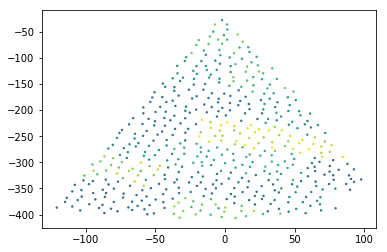

In [368]:
rads.compute()

Text(0, 0.5, 'REDROCK REDSHIFT')

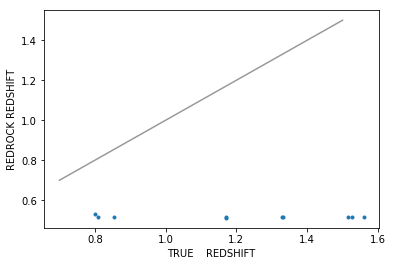

In [204]:
pl.plot(meta['REDSHIFT'], zbest['Z'], marker='.', lw=0.0)

pl.plot(np.arange(0.7, 1.6, 0.1), np.arange(0.7, 1.6, 0.1), c='k', alpha=0.4)

pl.xlabel('TRUE    REDSHIFT')
pl.ylabel('REDROCK REDSHIFT')

Text(0, 0.5, '$\\log_{10}|\\Delta \\chi^2|$')

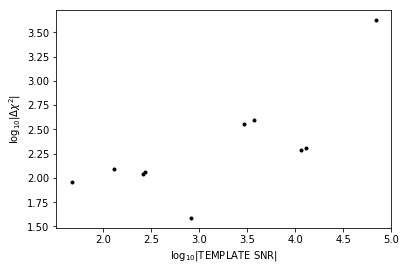

In [205]:
pl.plot(np.log10(meta['TEMPLATESNR']), np.log10(zbest['DELTACHI2']), marker='.', lw=0.0, c='k')

pl.xlabel('$\log_{10}$|TEMPLATE SNR|')
pl.ylabel('$\log_{10}|\Delta \chi^2|$')

# Appendix A:  Fiberloss correction on Flux Calibration Vector

In [80]:
# https://github.com/desihub/desispec/blob/6c9810df3929b8518d49bad14356d35137d25a89/py/desispec/fluxcalibration.py#L809

In [81]:
from desimodel.io import load_desiparams, load_fiberpos, load_platescale, load_tiles, load_deviceloc

In [82]:
def fiber_area_arcsec2(x, y):
  params       = load_desiparams()

  fiber_dia    = params['fibers']['diameter_um']
    
  x            = np.asarray(x)
  y            = np.asarray(y)

  r            = np.sqrt(x**2 + y**2)

  #- Platescales in um/arcsec
  ps           = load_platescale()

  # ps['radius'] in mm.
  radial_scale = np.interp(r, ps['radius'], ps['radial_platescale'])
  az_scale     = np.interp(r, ps['radius'], ps['az_platescale'])
 
  #- radial and azimuthal fiber radii in arcsec
  rr           = 0.5 * fiber_dia / radial_scale
  raz          = 0.5 * fiber_dia / az_scale

  fiber_area = (np.pi * rr * raz)

  return rr, raz, fiber_area 

In [83]:
fiber_area_arcsec2(0.0, 0.0)

(0.7927738217452752, 0.7927738209229515, 1.9744606092121348)

In [84]:
def moffatt(r, fwhm, beta=3.5):
  ##  Apparent radial profile of star-light due to buffeting by the atmosphere.  
  ##  Sec. 4 of https://iopscience.iop.org/article/10.1086/675808/pdf;  [arcsecond].                                                                                                                                                         
  alpha    = fwhm / 2. / (2.**(1./beta) - 1.)**0.5

  return  (2. * (beta - 1.) / alpha / alpha) * (1. + (r/alpha)**2.)**-beta

In [85]:
fwhm       = 2.0
dr         = 0.01

rs         = np.arange(0.0, 15., dr)  ## [arcseconds].        
ms         = moffatt(rs, fwhm)

In [86]:
theta      = 0.7927738217452752

(-0.1, 6.0)

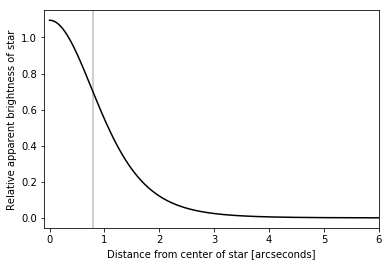

In [87]:
pl.axvline(theta, alpha=0.25, c='k')

pl.plot(rs, ms, c='k')
pl.xlabel('Distance from center of star [arcseconds]')
pl.ylabel('Relative apparent brightness of star')
pl.xlim(left=-0.1, right=6.0)

Text(0, 0.5, 'FIBER FRAC.')

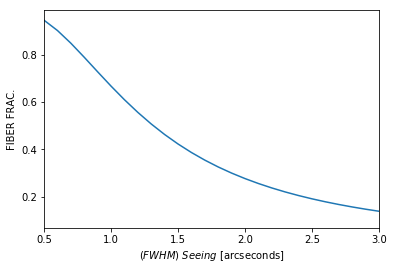

In [88]:
# A range of full-width @ half max. values for the seeing.  
fwhms      = np.arange(0.5, 3.5, 0.1)

# Find the index in our distance grid closest to the size of a fiber. 
indx       = np.abs(rs - theta).argmin()

# A list to collect the fraction of light down a fiber for each value of the seeing. 
fiberfracs = []

# Loop over the seeing values. 
for i, fwhm in enumerate(fwhms):
  # Work out the radial profile of the star.
  ms       = moffatt(rs, fwhm)
  
  # Integrate this to get the total light within a radius
  Is       = 2. * np.pi * dr * np.cumsum(rs * ms)

  # Calculate the fiber fraction for each r value we as for. 
  ffrac    = Is / Is[-1]
  
  # Save the fiber fraction for the radius corresponding to the fiber size. 
  fiberfracs.append(ffrac[indx])

fiberfracs = np.array(fiberfracs)

pl.plot(fwhms, fiberfracs)

pl.xlim(0.5, 3.0)

pl.xlabel(r'$(FWHM) \ Seeing \ [{\rm arcseconds}]$')
pl.ylabel(r'FIBER FRAC.')

## Done.